In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

## Data loading

,Vekt (tonn),Kilopris (kr)
uke,,
2000-01-03,3728,30.98
2000-01-10,4054,31.12
2000-01-17,4043,31.03
2000-01-24,3730,30.95
2000-01-31,3831,31.30
...,...,...
2023-07-17,17898,92.67
2023-07-24,19604,86.14
2023-07-31,20469,83.28


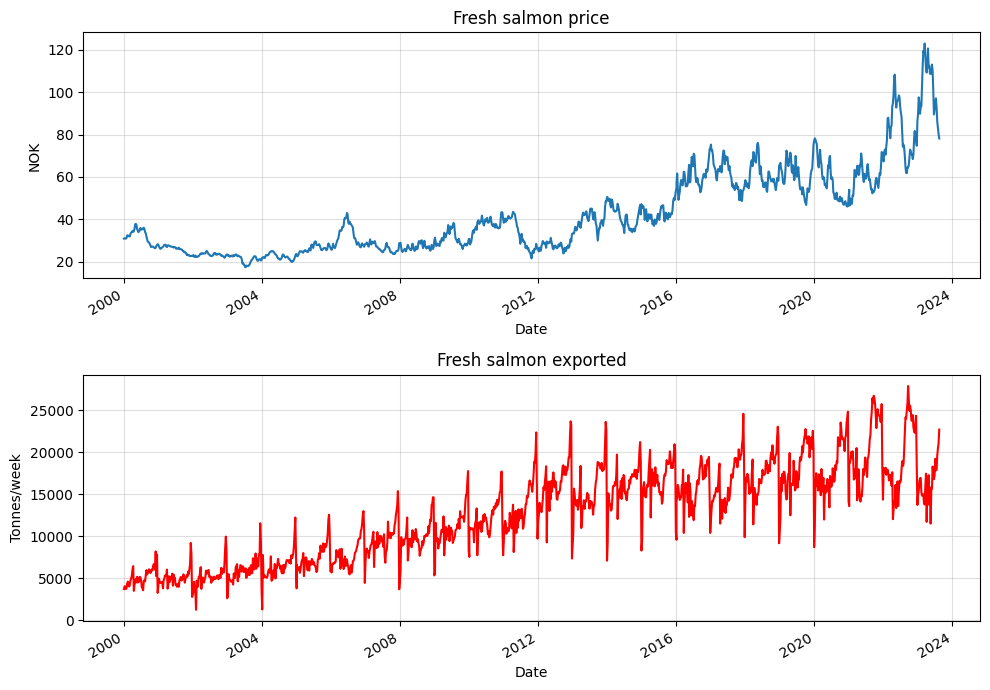

In [16]:
data = pd.read_csv('..\salmon_price_prediction\salmon_prices.csv', sep=';', skiprows=1)[['uke','Vekt (tonn)','Kilopris (kr)']]

# Change index to datetime format
date_series = pd.to_datetime(data['uke'].str[:4] + data['uke'].str[-2:] + '1', format='%Y%W%w')
data.set_index(date_series, inplace=True)
data.drop(['uke'], axis=1, inplace=True)

display(data)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 7))

data['Kilopris (kr)'].plot(ax=ax1, ylabel='NOK')
data['Vekt (tonn)'].plot(ax=ax2, color='red', ylabel='Tonnes/week')
ax1.set_title('Fresh salmon price')
ax2.set_title('Fresh salmon exported')
ax1.grid(alpha=0.4); ax2.grid(alpha=0.4)
ax1.set_xlabel('Date'); ax2.set_xlabel('Date')
fig.tight_layout()

## Feature extraction

,Vekt (tonn),Kilopris (kr),Year,Month,Quarter,Day of year
uke,,,,,,
2000-01-03,3728,30.98,2000,1,1,3
2000-01-10,4054,31.12,2000,1,1,10
2000-01-17,4043,31.03,2000,1,1,17
2000-01-24,3730,30.95,2000,1,1,24
2000-01-31,3831,31.30,2000,1,1,31
...,...,...,...,...,...,...
2023-07-17,17898,92.67,2023,7,3,198
2023-07-24,19604,86.14,2023,7,3,205
2023-07-31,20469,83.28,2023,7,3,212


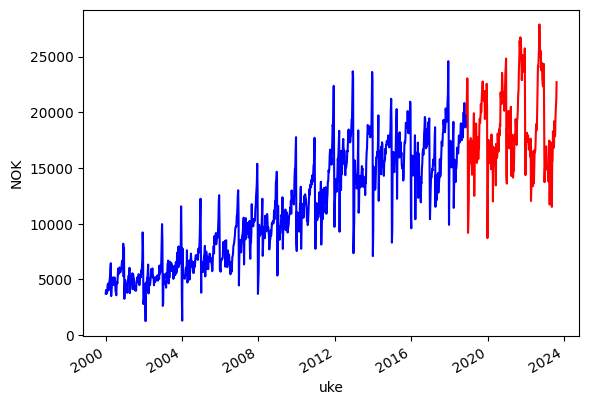

In [17]:
# Lag extraction
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter
data['Day of year'] = data.index.dayofyear

display(data)

train, test = train_test_split(data, test_size=0.2, shuffle=False)

fig, ax = plt.subplots()

train['Vekt (tonn)'].plot(ax=ax, ylabel='NOK', color='blue')
test['Vekt (tonn)'].plot(ax=ax, ylabel='NOK', color='red')

model = xgb.XGBRegressor()